In [14]:
import numpy as np
# import units as u
import numpy as np


import rasterio
from rasterio.plot import show_hist

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt

from icecream import ic



In [2]:
dni_path = "data/Nigeria_AvgDailyTotals_GlobalSolarAtlas_GEOTIFF/DNI.tif"
dataset = rasterio.open(dni_path)

In [16]:
dataset_vals = dataset.read()

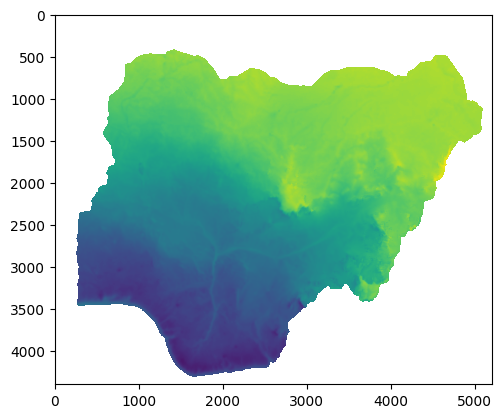

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.imshow(dataset_vals[0])

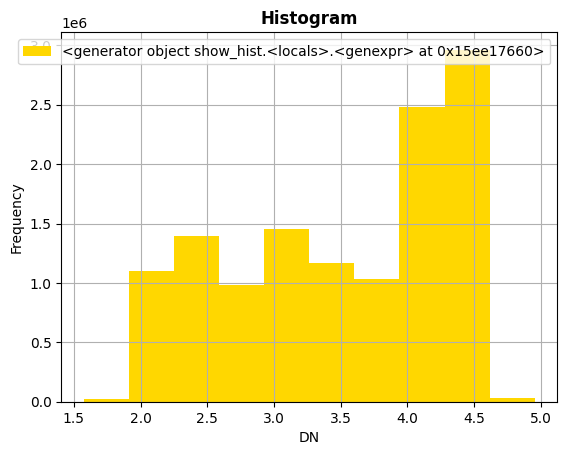

In [18]:
show_hist(dataset_vals[0])

In [21]:
dataset_vals0 = dataset_vals[0]
seg1 = (dataset_vals0 < 2.75)
seg2 = (dataset_vals0 > 2.75) & (dataset_vals0 < 4.0 )
seg3 = (dataset_vals0 > 4.0 )

In [24]:
all_segments = np.zeros((dataset_vals0.shape[0], dataset_vals0.shape[1], 3))

In [25]:
all_segments[seg1] = (1, 0, 0 )
all_segments[seg2] = (0, 1, 0 )
all_segments[seg3] = (0, 0, 1 )

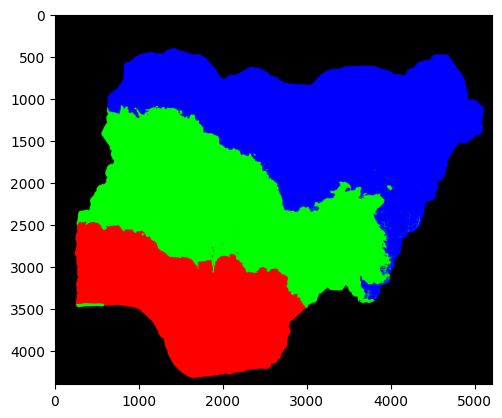

In [26]:
plt.imshow(all_segments)

In [19]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 5200,
 'height': 4400,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0025, 0.0, 2.0,
        0.0, -0.0025, 15.0)}

try to segment image based on DNI 

In [ ]:
affine = dataset.transform

In [72]:
rasterio.features.dataset_features(dataset, 1)

<generator object dataset_features at 0x126ad5c10>

Assume some made up information about horizantal solar flux of irradiance

In [32]:
N = 8
rng = np.random.default_rng(seed=1)

F_cur_spatial = np.round(rng.random((N,N)),1)

# need spatial information for wind and temperature as well
T_a_spatial = np.round(rng.uniform(low=20, high=32, size=(N,N)),2)
w_spatial = np.round(rng.rayleigh(scale=5, size=(N,N)),2)

F_cur_spatial # W/m^2 current solar flux normal to the panel 

array([[0.5, 1. , 0.1, 0.9, 0.3, 0.4, 0.8, 0.4],
       [0.5, 0. , 0.8, 0.5, 0.3, 0.8, 0.3, 0.5],
       [0.1, 0.4, 0.2, 0.3, 0.8, 0.3, 0.5, 1. ],
       [1. , 0.7, 0.5, 0.3, 0.2, 1. , 0.5, 0.1],
       [0.6, 0.8, 0.6, 0.9, 0. , 0.5, 0.5, 0.1],
       [0.6, 0.9, 0.6, 0.3, 0.8, 0.5, 0.5, 0.8],
       [0.1, 0.8, 0.7, 0.8, 0.2, 0.8, 0.2, 0.1],
       [0.9, 0.9, 0.9, 0.5, 0.3, 0. , 0.6, 0.7]])

In [18]:
fig = go.Figure()
fig = go.Figure(data=go.Heatmap(
                    z=F_cur_spatial))
fig.show()
# unsure what spatial dimension of heat flux data is but this could be something similiar potentially ...

In [55]:
def calculate_power_panel(F_cur, T_a, w):
    """
    F_cur = _ # W/m^2 current solar flux normal to the panel 
    T_a = _ # K / ºC, air temperature the panel is exposed to 
    w = _ # m/s, wind speed panel is exposed to 

    => all of these are 2x2 arrays with spatial information 
    
    """

    # values that change based on design! 
    D_f = 0.864 # derating factor, product of correction factors for additional processes affecting solar output, Table 5.2 
    E_panel = 0.18 # solar panel efficiency obtained under standard test conditions -- Ex 5.2
    A_panel = 1.5 # m^2, surface area of the pane -- Ex 5.2
    
    # 5.9, cell temperature, empirical so units do not eqate 
    T_c = T_a + 0.32 * (F_cur/(8.91 + 2*w))

    b_ref = 0.0025 # / K, temperature coefficient 
    T_th = 55 # K, threshold temeprature 
    T_ref = 298.15 # K, reference temperature 
    # 5.8, correction for cell temperature 
    C_temp = 1 - b_ref * np.maximum( np.minimum(T_c - T_ref, T_th ), 0 )

    # 5.7 actual AC power output from a solar panel at a given time 
    # P_ac = p_mpp_stc * C_temp * D_f / F_1000
    P_ac = F_cur * A_panel * E_panel * C_temp * D_f # units?? # should i be considering the rating of the panel as well? 

    return P_ac
    

In [58]:
single_panel_potential = calculate_power_panel(F_cur_spatial, T_a_spatial, w_spatial)

# this gives the P_ac of a single cell in a given area 

In [ ]:
# when this cell is in series / parallel, the maximum power point changes, Section 5.1.6 

# panels in series 
    # => open circuit voltage = sum ( open circuit voltage each panel), and v_mp increases
    # => short circuit current = same as initial panel
    # power => v_mp * i_mp 

In [57]:
# what is the spacing of the data in the gis file? => 250 m resolution 
# 5.1.5 => PV panel => 72, 96, or 128 pre-wired cells in series 
# one panel produces 0.5 - 0.7 V or energy potential 

# want to maximize voltage..

# hoq does p_ac change when the panel is in series / in parallel? am i supposed to know information about the voltage / current through this? here ill assume that the derating factor tales care of this, and just multiply by the size of the farm...

A_spacing = 250 #m2
A_panel = 1.5 # m2
n_panels = A_spacing / A_panel 
n_panels

166.66666666666666

In [59]:
# max possible power out for each region ...
farm_potenial = single_panel_potential * n_panels
farm_potenial # think this is instantaneous power? 

# need to get to energy and then compare energy production to energy needs ...


array([[19.44 , 38.88 ,  3.888, 34.992, 11.664, 15.552, 31.104, 15.552],
       [19.44 ,  0.   , 31.104, 19.44 , 11.664, 31.104, 11.664, 19.44 ],
       [ 3.888, 15.552,  7.776, 11.664, 31.104, 11.664, 19.44 , 38.88 ],
       [38.88 , 27.216, 19.44 , 11.664,  7.776, 38.88 , 19.44 ,  3.888],
       [23.328, 31.104, 23.328, 34.992,  0.   , 19.44 , 19.44 ,  3.888],
       [23.328, 34.992, 23.328, 11.664, 31.104, 19.44 , 19.44 , 31.104],
       [ 3.888, 31.104, 27.216, 31.104,  7.776, 31.104,  7.776,  3.888],
       [34.992, 34.992, 34.992, 19.44 , 11.664,  0.   , 23.328, 27.216]])